In [1]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #to plot charts
import seaborn as sns #used for data visualization
import warnings 
warnings.filterwarnings('ignore') # to ignore deprecated functions
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve


# A. Data Wrangling & Feature Engineering

In [3]:
# Load data using read_csv()
data = pd.read_csv('MedicalCentre.csv')
# the shape of a Dataframe
data.shape

(110527, 14)

In [4]:
# Show initial 5 records
data.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,2.990000e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62.0,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.590000e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56.0,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.260000e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62.0,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.680000e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8.0,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.840000e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56.0,JARDIM DA PENHA,0,1,1,0,0,0,No


## 1. Prepare the data for downstream processes, e.g., deal with missing values, duplicates 	

### Missing values

In [5]:
# check for missing values and duplicates
print("Missing values:\n", data.isnull().sum())
print("Duplicates:\n", data.duplicated().sum())

Missing values:
 PatientID         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               3
Neighbourhood     0
Scholarship       0
Hypertension      0
Diabetes          0
Alcoholism        0
Handicap          0
SMS_received      0
No-show           0
dtype: int64
Duplicates:
 0


There are 3 missing value in the age columns.

In [6]:
# Drop missing value rows using dropna() function
# deal with missing values
data = data.dropna()
data.shape

(110524, 14)

We can see that there is 110524 rows now, we drop 3 null values which is in the age columns.

### Duplicates 	

In [7]:
# drop duplicates
data = data.drop_duplicates()
data.shape

(110524, 14)

In [8]:
# delete the duplicate rows with same appointmentID. 
data = data.drop_duplicates(subset='AppointmentID', keep='first')
data.shape
# 这块也行，做个备注

(110524, 14)

In [9]:
##drop the patientID and AppointmentID
#data=data.drop(['PatientID','AppointmentID'],axis=1,inplace=False)
#print(data.shape)
#data.head()
# 这块我没有看懂为什么要把这两个都drop？

## 2. Determine the frequency of distinct values in each feature set

In [10]:
# Check the descriptive statistics
data.describe()

,PatientID,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received
count,1.105240e+05,1.105240e+05,110524.000000,110524.000000,110524.000000,110524.000000,110524.000000,110524.000000,110524.000000
mean,1.474991e+14,5.675306e+06,37.088488,0.098268,0.197251,0.071867,0.030401,0.022249,0.321025
std,2.560970e+14,7.129616e+04,23.110271,0.297678,0.397925,0.258268,0.171688,0.161545,0.466873
min,3.920000e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.170000e+12,5.640287e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.170000e+13,5.680575e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.440000e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000e+15,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [11]:
for column in data.columns:
    print(column)
    print(data[column].value_counts())
    print()

PatientID
8.220000e+14    141
3.350000e+13    127
7.580000e+13    124
8.190000e+13    123
2.690000e+13    117
               ... 
6.978773e+10      1
9.847957e+10      1
4.226995e+10      1
5.734915e+10      1
9.481592e+10      1
Name: PatientID, Length: 6100, dtype: int64

AppointmentID
5642903    1
5675362    1
5647618    1
5687640    1
5740664    1
          ..
5441938    1
5565998    1
5718442    1
5426425    1
5629448    1
Name: AppointmentID, Length: 110524, dtype: int64

Gender
F    71838
M    38686
Name: Gender, dtype: int64

ScheduledDay
2016-05-06T07:09:54Z    24
2016-05-06T07:09:53Z    23
2016-04-25T17:17:46Z    22
2016-04-25T17:18:27Z    22
2016-04-25T17:17:23Z    19
                        ..
2016-05-16T09:12:51Z     1
2016-05-09T10:48:50Z     1
2016-05-02T09:53:25Z     1
2016-05-30T09:12:28Z     1
2016-04-27T13:30:56Z     1
Name: ScheduledDay, Length: 103546, dtype: int64

AppointmentDay
2016-06-06T00:00:00Z    4692
2016-05-16T00:00:00Z    4613
2016-05-09T00:00:00Z    452

In [12]:
# check frequency of distinct values
for col in data.columns:
    print(col, data[col].nunique())

PatientID 6100
AppointmentID 110524
Gender 2
ScheduledDay 103546
AppointmentDay 27
Age 104
Neighbourhood 81
Scholarship 2
Hypertension 2
Diabetes 2
Alcoholism 2
Handicap 5
SMS_received 2
No-show 2


## 3. Initialize a function to plot relevant features within the dataset to visualize for outliers

<AxesSubplot:xlabel='Gender', ylabel='count'>

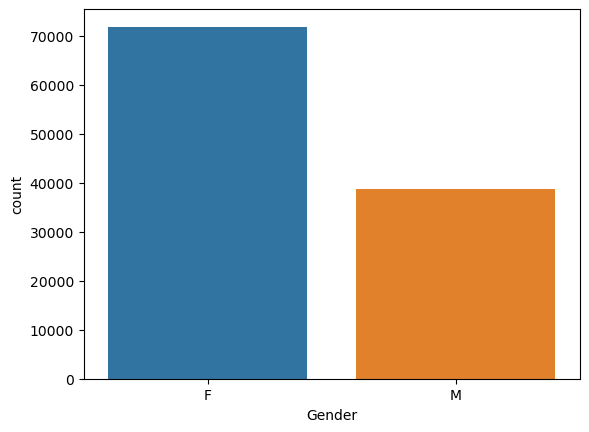

In [13]:
sns.countplot('Gender',data=data)

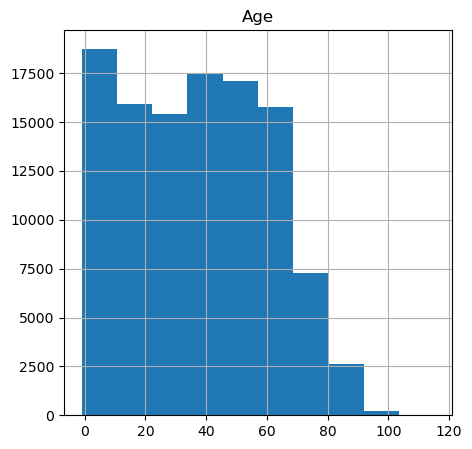

In [14]:
# histogram for each feature
data.hist(column='Age',bins=10,figsize=(5,5))
plt.show()

<AxesSubplot:xlabel='Age'>

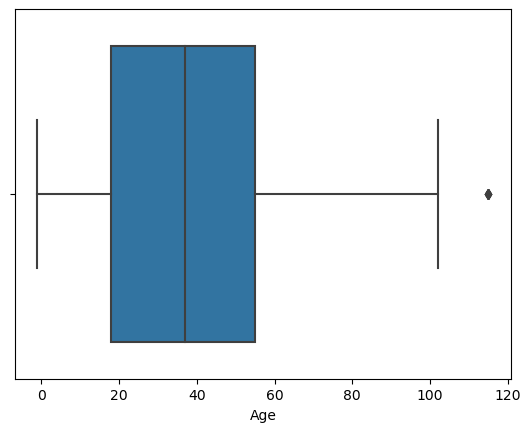

In [15]:
sns.boxplot(x='Age',data=data)
plt.subplot()

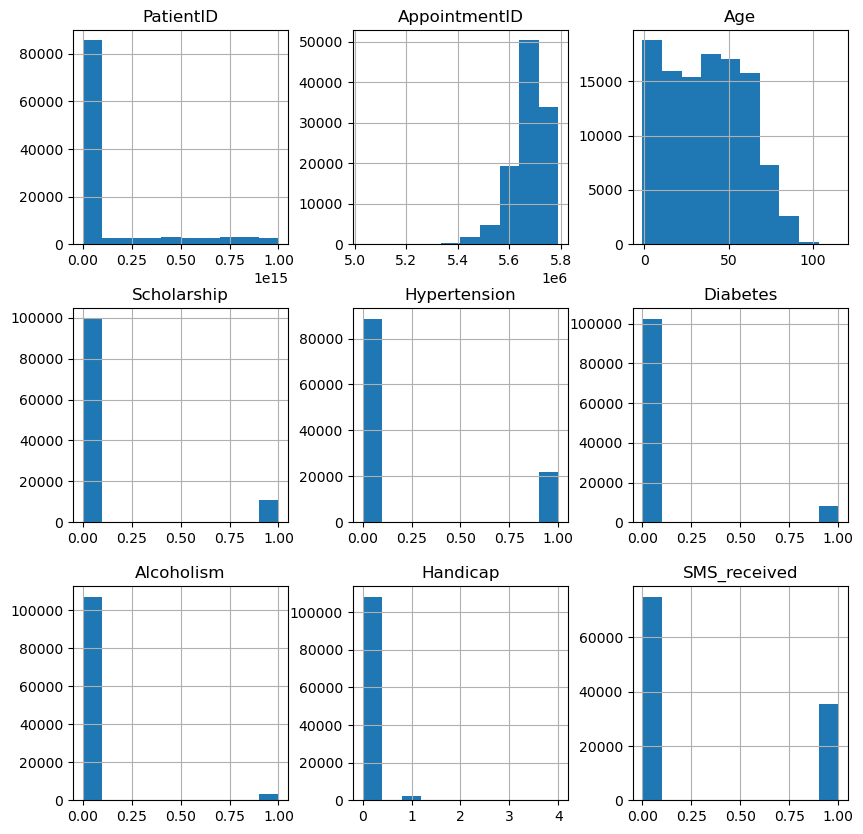

In [16]:
# histogram for each feature
data.hist(bins=10,figsize=(10,10))
plt.show() 

## 4.  Count the frequency of negative Age feature observations, and remove them

In [17]:
# count the frequency of nagative age feature observation
print("Negative Age values:", (data["Age"] < 0).sum())
# Filter age who under zero and delete. 
data[(data.Age <0)]

Negative Age values: 1


,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
99832,4.660000e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1.0,ROMÃO,0,0,0,0,0,0,No


In [18]:
# remove negative age 
data = data[data["Age"] >= 0]

In [19]:
# data=data.drop([99832],axis=0,inplace=False)
# 这块代码有风险，在于如果它不是在99832这行，那么就没办法drop，我推荐用上面的的方式


## 5. The values within AwaitingTime are negative, transform them into positive values

In [20]:
# Convert the ScheduledDay and AppointmentDay columns to datetime
data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay'])
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay'])

# Calculate the waiting time and convert it to days
data['AwaitingTime'] = (data['ScheduledDay'] - data['AppointmentDay']).dt.days

# transform them into positive values
data["AwaitingTime"] = abs(data["AwaitingTime"])

## 6. ML algorithm requires the variables to be coded into its equivalent integer codes. Encode the string categorical values into an integer code

In [21]:
# check the information of dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110523 entries, 0 to 110526
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientID       110523 non-null  float64            
 1   AppointmentID   110523 non-null  int64              
 2   Gender          110523 non-null  object             
 3   ScheduledDay    110523 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110523 non-null  datetime64[ns, UTC]
 5   Age             110523 non-null  float64            
 6   Neighbourhood   110523 non-null  object             
 7   Scholarship     110523 non-null  int64              
 8   Hypertension    110523 non-null  int64              
 9   Diabetes        110523 non-null  int64              
 10  Alcoholism      110523 non-null  int64              
 11  Handicap        110523 non-null  int64              
 12  SMS_received    110523 non-null  int64              
 13  No-show       

In [22]:
le = LabelEncoder()
#data["PatientID"] = le.fit_transform(data["PatientID"])
data["Gender"] = le.fit_transform(data["Gender"])
#data["ScheduledDay"] = le.fit_transform(data["ScheduledDay"])
#data["AppointmentDay"] = le.fit_transform(data["AppointmentDay"])
#data["Age"] = le.fit_transform(data["Age"])
data["Neighbourhood"] =  le.fit_transform(data["Neighbourhood"])
data["No-show"] = le.fit_transform(data["No-show"])
# check all data type into an integer code
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110523 entries, 0 to 110526
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientID       110523 non-null  float64            
 1   AppointmentID   110523 non-null  int64              
 2   Gender          110523 non-null  int64              
 3   ScheduledDay    110523 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110523 non-null  datetime64[ns, UTC]
 5   Age             110523 non-null  float64            
 6   Neighbourhood   110523 non-null  int64              
 7   Scholarship     110523 non-null  int64              
 8   Hypertension    110523 non-null  int64              
 9   Diabetes        110523 non-null  int64              
 10  Alcoholism      110523 non-null  int64              
 11  Handicap        110523 non-null  int64              
 12  SMS_received    110523 non-null  int64              
 13  No-show       

## 7. Separate the date features into date components

In [23]:
data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay'])
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay'])
data['ScheduledDay_year'] = data['ScheduledDay'].dt.year
data['ScheduledDay_month'] = data['ScheduledDay'].dt.month
data['ScheduledDay_day'] = data['ScheduledDay'].dt.day
data['ScheduledDay_hour'] = data['ScheduledDay'].dt.hour
data['AppointmentDay_year'] = data['AppointmentDay'].dt.year
data['AppointmentDay_month'] = data['AppointmentDay'].dt.month
data['AppointmentDay_day'] = data['AppointmentDay'].dt.day

In [24]:
# parse_dates=['ScheduledDay','AppointmentDay']

In [25]:
# data.ScheduledDay=data.ScheduledDay.str.replace('T',' ')
# data.ScheduledDay=data.ScheduledDay.str.replace('Z','')
# data.ScheduledDay[0]

In [26]:
# data.AppointmentDay=data.AppointmentDay.str.replace('T',' ')
# data.AppointmentDay=data.AppointmentDay.str.replace('Z','')
# data.AppointmentDay[0]

In [27]:
# data.ScheduledDay=pd.to_datetime(data['ScheduledDay'], format='%Y-%m-%d %H:%M:%S')
# data.AppointmentDay=pd.to_datetime(data['AppointmentDay'], format='%Y-%m-%d %H:%M:%S')
# data.ScheduledDay[0]

In [28]:
# data.ScheduledDay[42]-data.AppointmentDay[42]

In [29]:
# data.dtypes

In [30]:
# data['AwaitingTime']=data['ScheduledDay']-data['AppointmentDay']

In [31]:
# data.describe()

In [32]:
# data['AwaitingTime'] < '%0-%0-%0 %0:%0:%0'

# 6. ML algorithm requires the variables to be coded into its equivalent integer codes. Encode the string categorical values into an integer code

In [33]:
# data.dtypes

In [34]:
# data['Age'] = data['Age'].apply(np.int64)

In [35]:
# data['Gender'].replace('F', 0,inplace=True)
# data['Gender'].replace('M', 1,inplace=True)
# data['Gender'] = data['Gender'].apply(np.int64)
# data.dtypes

In [36]:
# data['No-show'].replace('No', 0,inplace=True)
# data['No-show'].replace('Yes', 1,inplace=True)
# data['No-show'] = data['No-show'].apply(np.int64)
# data.dtypes

In [37]:
# data.dtypes

## 8. ML algorithms work best when the input data are scaled to a narrow range around zero. Rescale the age feature with a normalizing (e.g., min_max normalization) or standardization (e.g., z_score standardization) function.

### (1)normalization ( min_max normalization)

In [38]:
data.Age_norm=(data.Age-data.Age.min())/(data.Age.max()-data.Age.min())

### (2)standardization (e.g., z_score standardization)

In [39]:
# Z-Score using pandas
(data.Age_norm - data.Age_norm.mean()) / data.Age_norm.std()

0         1.077935
1         0.818308
2         1.077935
3        -1.258707
4         0.818308
            ...   
110522    0.818308
110523    0.601952
110524   -0.696182
110525    0.039427
110526    0.731766
Name: Age, Length: 110523, dtype: float64

In [40]:
data.describe()

,PatientID,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,AwaitingTime,ScheduledDay_year,ScheduledDay_month,ScheduledDay_day,ScheduledDay_hour,AppointmentDay_year,AppointmentDay_month,AppointmentDay_day
count,1.105230e+05,1.105230e+05,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.0,110523.000000,110523.000000
mean,1.474963e+14,5.675306e+06,0.350027,37.088832,41.736869,0.098269,0.197253,0.071867,0.030401,0.022249,0.321028,0.201940,10.184143,2015.999439,4.823883,14.252011,10.774445,2016.0,5.210074,12.499009
std,2.560964e+14,7.129585e+04,0.476980,23.110091,22.361834,0.297680,0.397927,0.258269,0.171689,0.161546,0.466874,0.401449,15.255065,0.023678,0.715792,9.345561,3.216137,0.0,0.473741,9.056217
min,3.920000e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,6.000000,2016.0,4.000000,1.000000
25%,4.170000e+12,5.640286e+06,0.000000,18.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000,4.000000,6.000000,8.000000,2016.0,5.000000,5.000000
50%,3.170000e+13,5.680574e+06,0.000000,37.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2016.000000,5.000000,13.000000,10.000000,2016.0,5.000000,10.000000
75%,9.440000e+13,5.725524e+06,1.000000,55.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,15.000000,2016.000000,5.000000,22.000000,13.000000,2016.0,5.000000,19.000000
max,1.000000e+15,5.790484e+06,1.000000,115.000000,80.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,179.000000,2016.000000,12.000000,31.000000,21.000000,2016.0,6.000000,31.000000


In [41]:
# Initialize the scaler
scaler = MinMaxScaler()

# Scale the Age feature
data['Age_Norm'] = scaler.fit_transform(data[['Age']])

data.describe()

,PatientID,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,...,No-show,AwaitingTime,ScheduledDay_year,ScheduledDay_month,ScheduledDay_day,ScheduledDay_hour,AppointmentDay_year,AppointmentDay_month,AppointmentDay_day,Age_Norm
count,1.105230e+05,1.105230e+05,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,...,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.0,110523.000000,110523.000000,110523.000000
mean,1.474963e+14,5.675306e+06,0.350027,37.088832,41.736869,0.098269,0.197253,0.071867,0.030401,0.022249,...,0.201940,10.184143,2015.999439,4.823883,14.252011,10.774445,2016.0,5.210074,12.499009,0.322512
std,2.560964e+14,7.129585e+04,0.476980,23.110091,22.361834,0.297680,0.397927,0.258269,0.171689,0.161546,...,0.401449,15.255065,0.023678,0.715792,9.345561,3.216137,0.0,0.473741,9.056217,0.200957
min,3.920000e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2015.000000,1.000000,1.000000,6.000000,2016.0,4.000000,1.000000,0.000000
25%,4.170000e+12,5.640286e+06,0.000000,18.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2016.000000,4.000000,6.000000,8.000000,2016.0,5.000000,5.000000,0.156522
50%,3.170000e+13,5.680574e+06,0.000000,37.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.000000,2016.000000,5.000000,13.000000,10.000000,2016.0,5.000000,10.000000,0.321739
75%,9.440000e+13,5.725524e+06,1.000000,55.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,15.000000,2016.000000,5.000000,22.000000,13.000000,2016.0,5.000000,19.000000,0.478261
max,1.000000e+15,5.790484e+06,1.000000,115.000000,80.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,1.000000,179.000000,2016.000000,12.000000,31.000000,21.000000,2016.0,6.000000,31.000000,1.000000


# 9 Conduct variability comparison between features using a correlation matrix & drop correlated features

In [42]:
# Calculate the correlation matrix
data_selected = data.drop(['PatientID', 'AppointmentID', 'ScheduledDay_year', 'ScheduledDay_day', 'ScheduledDay_hour', 
                           'AppointmentDay_year', 'AppointmentDay_month', 'AppointmentDay_day'], axis = 'columns')
corr_matrix = data_selected.corr()
corr_matrix

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,AwaitingTime,ScheduledDay_month,Age_Norm
Gender,1.000000,-0.106468,-0.008041,-0.114298,-0.055723,-0.032557,0.106168,0.022814,-0.046331,-0.004123,-0.028424,0.013337,-0.106468
Age,-0.106468,1.000000,-0.016344,-0.092459,0.504601,0.292399,0.095814,0.078035,0.012619,-0.060319,0.034824,-0.002997,1.000000
Neighbourhood,-0.008041,-0.016344,1.000000,0.006872,0.004332,0.011352,-0.000007,0.010993,0.018286,-0.008952,-0.002032,0.009290,-0.016344
Scholarship,-0.114298,-0.092459,0.006872,1.000000,-0.019735,-0.024897,0.035020,-0.008588,0.001192,0.029129,-0.030431,0.016807,-0.092459
Hypertension,-0.055723,0.504601,0.004332,-0.019735,1.000000,0.433083,0.087968,0.080081,-0.006270,-0.035711,-0.017230,0.024985,0.504601
Diabetes,-0.032557,0.292399,0.011352,-0.024897,0.433083,1.000000,0.018472,0.057529,-0.014552,-0.015185,-0.027196,0.025592,0.292399
Alcoholism,0.106168,0.095814,-0.000007,0.035020,0.087968,0.018472,1.000000,0.004647,-0.026149,-0.000199,-0.038525,0.028769,0.095814
Handicap,0.022814,0.078035,0.010993,-0.008588,0.080081,0.057529,0.004647,1.000000,-0.024162,-0.006079,-0.019833,0.014951,0.078035
SMS_received,-0.046331,0.012619,0.018286,0.001192,-0.006270,-0.014552,-0.026149,-0.024162,1.000000,0.126430,0.398136,-0.294091,0.012619
No-show,-0.004123,-0.060319,-0.008952,0.029129,-0.035711,-0.015185,-0.000199,-0.006079,0.126430,1.000000,0.186249,-0.160875,-0.060319


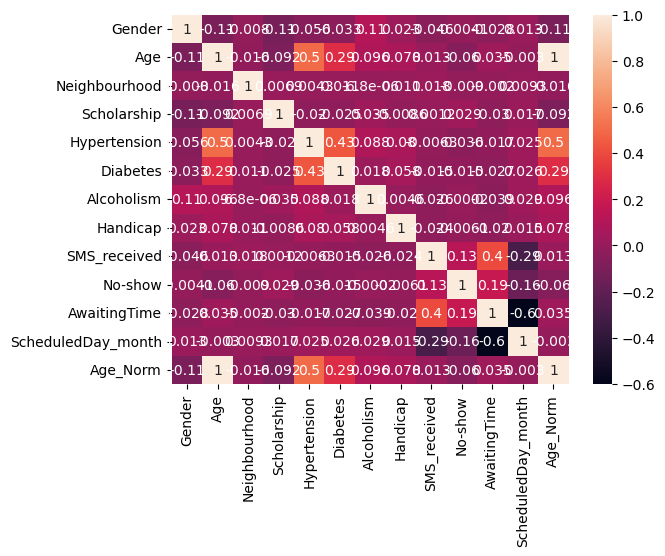

In [43]:
# Visualize the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True)

# Identify highly correlated features
highly_correlated = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            highly_correlated.add(colname)


In [44]:
# Drop highly correlated features
data = data.drop(columns=highly_correlated)

# B. Model Development : Naïve Bayes classifier

In [45]:
# Select relevant features for the classifier
features = ['Gender', 'Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 
            'SMS_received', 'AwaitingTime']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data['No-show'], test_size=0.3, random_state=1)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

# Initialize the classifier
nb = GaussianNB()

# Train the classifier
nb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


(77366, 9) (77366,)
(33157, 9) (33157,)
Accuracy: 0.7696112434779986


Classification Report is:
               precision    recall  f1-score   support

           0       0.81      0.93      0.87     26477
           1       0.33      0.14      0.20      6680

    accuracy                           0.77     33157
   macro avg       0.57      0.53      0.53     33157
weighted avg       0.71      0.77      0.73     33157


 F1:
 0.19716237519705726

 Precision score is:
 0.3308641975308642

 Recall score is:
 0.1404191616766467

 Confusion Matrix:



<AxesSubplot:>

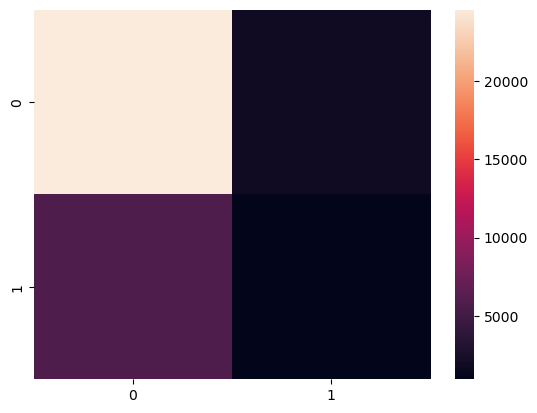

In [46]:
print("Classification Report is:\n",classification_report(y_test, y_pred))
print("\n F1:\n",f1_score(y_test, y_pred))
print("\n Precision score is:\n",precision_score(y_test, y_pred))
print("\n Recall score is:\n",recall_score(y_test, y_pred))
print("\n Confusion Matrix:\n")
sns.heatmap(confusion_matrix(y_test, y_pred))

# C. Model Evaluation & Comparison

## 1. Write a Function to detect the model’s Accuracy by applying the trained model on a testing dataset to find the predicted labels of Status. Was there overfitting?

In [47]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Predict the test set labels
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Predict the training set labels
    y_train_pred = model.predict(X_train)

    # Calculate training set accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Check for overfitting
    overfitting = train_accuracy - accuracy

    # Print the results
    print("Accuracy on test set:", accuracy)
    print("Accuracy on training set:", train_accuracy)
    print("Overfitting:", overfitting)

## 2. Tune the model using GridSearchCV

In [48]:
# Set the range of hyperparameters
param_grid_nb = {
    'var_smoothing': np.logspace(0,-2, num=100)
}

# Create the GridSearchCV object
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)

# Fit the GridSearchCV object to the training data
nbModel_grid.fit(X_train, y_train)

# Get the best hyperparameters
best_params = nbModel_grid.best_params_
print('Best Parameters:', best_params)

# Get the best model
best_gnb = nbModel_grid.best_estimator_


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Parameters: {'var_smoothing': 1.0}


## 3. Using the same data set partitioning method, evaluate the performance of a SVM and Decision tree classifier on the dataset. Compare the results of the Naïve Bayes classifier with SVM and Decision tree model according to the following criteria: Accuracy, Sensitivity, Specificity & F1 score. Identify the model that performed best and worst according to each criterion.

In [49]:
# SVM
svm = SVC()
# svm = SVC(C=1.0, kernel='linear', gamma='auto')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_report = classification_report(y_test, svm_pred)

# Decision tree
dt = DecisionTreeClassifier(random_state=42)
# dt = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_report = classification_report(y_test, dt_pred)

nb_pred = best_gnb.predict(X_test)
nb_report = classification_report(y_test, nb_pred)

print('SVM Performance:\n', svm_report)
print('Decision Tree Performance:\n', dt_report)
print('Naive Bayes Performance:\n', nb_report)

SVM Performance:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     26477
           1       0.00      0.00      0.00      6680

    accuracy                           0.80     33157
   macro avg       0.40      0.50      0.44     33157
weighted avg       0.64      0.80      0.71     33157

Decision Tree Performance:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86     26477
           1       0.34      0.19      0.25      6680

    accuracy                           0.76     33157
   macro avg       0.58      0.55      0.55     33157
weighted avg       0.72      0.76      0.74     33157

Naive Bayes Performance:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     26477
           1       0.22      0.00      0.00      6680

    accuracy                           0.80     33157
   macro avg       0.51      0.50      0.44     33157
we

## 4. Carry out a ROC analysis to compare the performance of the Naïve Bayes, SVM model with the Decision Tree model. Plot the ROC graph of the models. 

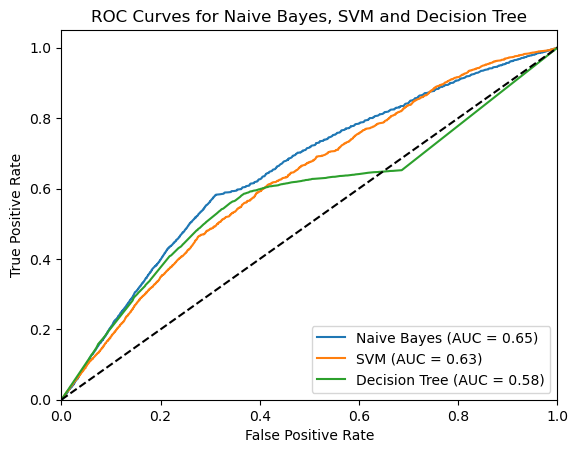

In [52]:
# Compute ROC and AUC for Naive Bayes
nb_pred_prob = best_gnb.predict_proba(X_test)[:, 1]
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_test, nb_pred_prob)
nb_auc = roc_auc_score(y_test, nb_pred_prob)

# Compute ROC and AUC for SVM
svm_pred_prob = svm.decision_function(X_test)
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, svm_pred_prob)
svm_auc = roc_auc_score(y_test, svm_pred_prob)

# Compute ROC and AUC for Decision Tree
dt_pred_prob = dt.predict_proba(X_test)[:, 1]
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dt_pred_prob)
dt_auc = roc_auc_score(y_test, dt_pred_prob)

# Plot ROC curves for all classifiers
plt.plot(nb_fpr, nb_tpr, label='Naive Bayes (AUC = %0.2f)' % nb_auc)
plt.plot(svm_fpr, svm_tpr, label='SVM (AUC = %0.2f)' % svm_auc)
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (AUC = %0.2f)' % dt_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Naive Bayes, SVM and Decision Tree')
plt.legend(loc="lower right")
plt.show()
